<script>
  jQuery(document).ready(function($) {

  $(window).load(function(){
    $('#preloader').fadeOut('slow',function(){$(this).remove();});
  });

  });
</script>

<style type="text/css">
  div#preloader { position: fixed;
      left: 0;
      top: 0;
      z-index: 999;
      width: 100%;
      height: 100%;
      overflow: visible;
      background: #fff url('http://preloaders.net/preloaders/720/Moving%20line.gif') no-repeat center center;
  }
</style>

<div id="preloader"></div>

# Exploring the Statistics of Milk Production: Temperature

## Background

This notebook is intended to test hypotheses relating to weather and milk production, based on diary .  For additional context please see the [summary notebook](./statistics_of_milk_production.ipynb).

---

## Selected Terms

The following terms and definitions should be useful for understanding the contents of this analysis.  

- **Milk Weight:** The amount of milk produced by an animal.  Measured in pounds of milk. For reference, a gallon of milk weighs approximately 8.6 pounds.
- **Extreme Temperature Day:** A day were the maximum temperature excedes 90(F) or the minimum temperature is below 10(F). 

---

## Hypotheses

The analysis seeks to test the following hypotheses:

### Maximum Temperature and Milk Weight

- **$H_{o Tmax}$:** The weekly average of maximum temperatures is not linearly correlated with weekly per-capita milk production.
- **$H_{a Tmax}$:** The weekly average of maximum temperatures is linearly correlated with weekly per-capita milk production.

### Minimum Temperature and Milk Weight

- **$H_{o Tmin}$:** The weekly average of minimum temperatures is not linearly correlated with weekly per-capita milk production.
- **$H_{a Tmin}$:** The weekly average of minimum temperatures not linearly correlated with weekly per-capita milk production.

### Extreme Temperature and Milk Weight

- **$H_{o Tex}$:** The number of extreme temperature days per week is not linearly correlated with per-capita weekly milk production.
- **$H_{a Tex}$:** The number of extreme temperature days per week is not linearly correlated with per-capita weekly milk production.

---

### Conclusions

No statistically signiciant linear correlation was found between weekly milk production and maximum temperature, weekly milk production and minimum temperature, or weekly production and days of extreme temperature.  As a result we cannot reject any of the null hypotheses above.

In [5]:
import sys
sys.path.insert(0, '../scripts')
sys.path.insert(0, '../data/database')
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Data Retrieval
engine =  create_engine('sqlite:///../data/database/happycows.db')
with engine.connect() as con:
    milk = pd.read_sql_table('milk_volume', con)
    weather = pd.read_sql_table('weather', con)


In [3]:
milk.sample(3)

,date,animal_id,milk_weight,average_flow,max_flow
120169,2017-10-06,2118,33.5,2.45,4.0
101847,2017-05-18,1994,58.6,3.80,6.0
31066,2016-02-02,2001,26.4,3.70,5.1


In [4]:
weather.sample(3)

,index,date,prcp,tmin,tmax,is_hot,is_heatwave,is_cold,is_coldwave
1335,239,2017-08-28,0.000000,52.0,73.0,False,False,False,False
219,219,2014-08-08,0.000000,52.5,77.0,False,False,False,False
825,95,2016-04-05,0.023333,22.5,53.0,False,False,False,False


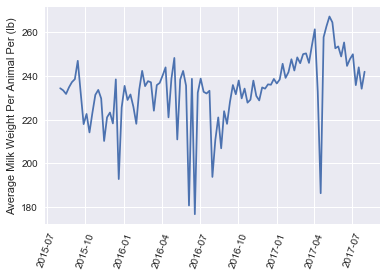

In [5]:
def select_features(data):
    return data[['date', 'animal_id', 'milk_weight']]
    
def transform_date(data):
    data['date'] = pd.to_datetime(data['date'].dt.date)
    return data

def get_daily_animal_milk_weight(data):
    return data.groupby(['date', 'animal_id']).sum().reset_index()

def get_daily_herd_average_milk_weight(data):
    return data.reset_index().groupby('date').mean()['milk_weight'].reset_index()

def get_weekly_totals(data):
    return data.set_index('date').resample('W').sum().reset_index()
    

milk = select_features(milk)
milk = transform_date(milk)
milk = get_daily_animal_milk_weight(milk)
milk = get_daily_herd_average_milk_weight(milk)
milk = get_weekly_totals(milk)
milk = milk.set_index('date')['2015-08-01':'2017-07-30']

sns.set()
_ = plt.plot(milk)
_ = plt.ylabel('Average Milk Weight Per Animal Per (lb)')
_ = plt.xticks(rotation=70)
plt.show()


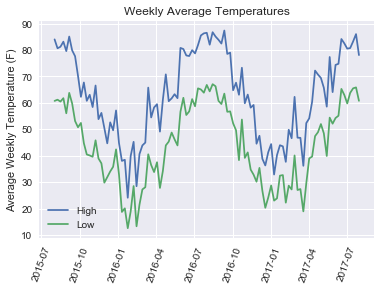

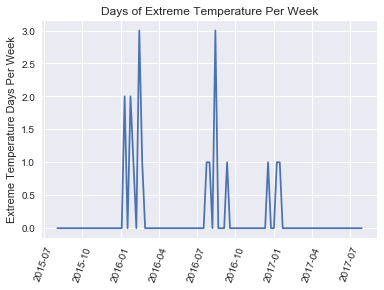

In [6]:
def get_weekly_summary(data):
    ws = pd.DataFrame()
    ws['average_max_temp'] = data.resample('W').mean()['tmax']
    ws['average_min_temp'] = data.resample('W').mean()['tmin']
    ws['extreme_days'] = data.resample('W').sum()['is_hot'] + data.resample('W').sum()['is_cold'] 
    return ws

weather = weather.set_index('date')['2015-08-01':'2017-07-30']
weekly_summary = get_weekly_summary(weather)

sns.set()
_ = plt.plot(weekly_summary[['average_max_temp', 'average_min_temp']])
_ = plt.ylabel('Average Weekly Temperature (F)')
_ = plt.xticks(rotation=70)
_ = plt.title("Weekly Average Temperatures")
plt.legend(['High', 'Low'])
plt.show()

_ = plt.plot(weekly_summary[['extreme_days']])
_ = plt.ylabel('Extreme Temperature Days Per Week')
_ = plt.title("Days of Extreme Temperature Per Week")
_ = plt.xticks(rotation=70)
plt.show()

In [7]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0,1]

def calculate_correlation_and_p_value(x, y, permutations=10000, alpha=0.05):
    obs_r = pearson_r(x, y)
    perm_replicates = np.empty(permutations)
    for i in range(permutations):
        y_permutated = np.random.permutation(y)
        perm_replicates[i] = pearson_r(x, y_permutated)
    
    p = np.sum(perm_replicates >= obs_r) / len(perm_replicates)
    
    print(f'     r = {obs_r}')
    print(f' p-val = {p}')
    print(f' alpha = {alpha}\n')
    if p < alpha:
        print(f"The correlation is statistically significant at p-value: {p} and alpha: {alpha}\n")
    else:
        print(f"The correlation is not statistically significant at p-value: {p} and alpha: {alpha}\n")
    return obs_r, p

def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""
    inds = np.arange(len(x))
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

def conduct_analysis(x, y, x_label, y_label, title):
    """Conduct repeated plot and analysis"""
    slopes, intercepts = draw_bs_pairs_linreg(x, y, 100)
    x_range = np.array([min(x), max(x)])
    for i in range(100):
        _ = plt.plot(x_range, slopes[i]*x_range + intercepts[i],
                     linewidth=0.5, alpha=0.2, color='red')
    
    _ = plt.scatter(x, y)
    _ = plt.xlabel(x_label)
    _ = plt.ylabel(y_label)
    _ = plt.title(title)
    r, p = calculate_correlation_and_p_value(x, y)
    plt.show()

## Analysis and Results

### H-Tmax: Maximum Temperature and Milk Weight

No statistically significant linear correlation was found between Maximum Temperature and Milk Production.  As a result we cannot reject Ho-Tmax at this time.

     r = -0.15689969983791777
 p-val = 0.9453
 alpha = 0.05

The correlation is not statistically significant at p-value: 0.9453 and alpha: 0.05



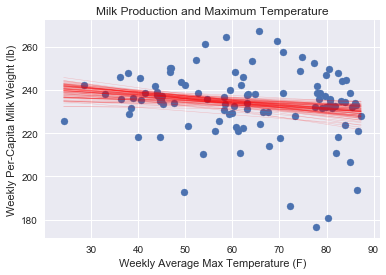

In [8]:
# Hypothesis Test Ho-Tmax
x = weekly_summary['average_max_temp']
x_label = 'Weekly Average Max Temperature (F)'
y = milk['milk_weight']
y_label = 'Weekly Per-Capita Milk Weight (lb)'
title = 'Milk Production and Maximum Temperature'

conduct_analysis(x, y, x_label, y_label, title)    

### H-Tmin: Minimum Temperature and Milk Weight

No statistically significant linear correlation was found between Minimum Temperature and Milk Production.  As a result we cannot reject Ho-Tmin at this time.

     r = -0.1545959699981437
 p-val = 0.9489
 alpha = 0.05

The correlation is not statistically significant at p-value: 0.9489 and alpha: 0.05



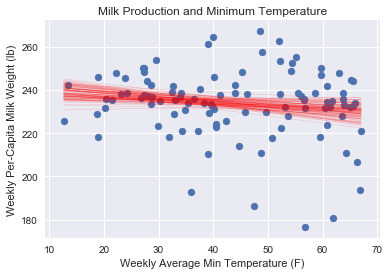

In [9]:
# Hypothesis Test Ho-Tmax
x = weekly_summary['average_min_temp']
x_label = 'Weekly Average Min Temperature (F)'
y = milk['milk_weight']
y_label = 'Weekly Per-Capita Milk Weight (lb)'
title = 'Milk Production and Minimum Temperature'

conduct_analysis(x, y, x_label, y_label, title)    

### H-Tmin: Extreme Temperature and Milk Weight

No statistically significant linear correlation was found between Days of Extreme Temperature and Milk Production.  As a result we cannot reject Ho-Tex at this time.

     r = -0.08601174999363977
 p-val = 0.8083
 alpha = 0.05

The correlation is not statistically significant at p-value: 0.8083 and alpha: 0.05



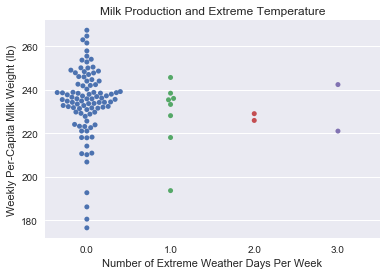

In [10]:
# Hypothesis Test Ho-Tex
x = weekly_summary['extreme_days']
y = milk['milk_weight']

r, p = calculate_correlation_and_p_value(x, y)
sns.swarmplot(x, y)
_ = plt.xlabel('Number of Extreme Weather Days Per Week')
_ = plt.ylabel('Weekly Per-Capita Milk Weight (lb)')
_ = plt.title('Milk Production and Extreme Temperature')
plt.show()